# Load the model

In [5]:
# Imports
from transformers import AlbertForTokenClassification, AutoModelForTokenClassification, pipeline
from transformers import TrainingArguments, Trainer, DataCollatorForTokenClassification
from transformers import AutoTokenizer
from transformers import RobertaTokenizer, RobertaForMaskedLM, RobertaModel
from transformers import BertTokenizer

from finetune_model import RobertaNER, BertNER
import torch
import json


In [2]:
version = "version_1"
save_name = "albert_ner_model_"+ version

In [186]:
# label_list = ['I-Userbase_Information',
#  'I-Software_Purpose',
#  'I-Internal_Organization',
#  'B-Software_Name',
#  'I-Data_Scalability',
#  'B-Development_Scalability',
#  'I-Development_Scalability',
#  'B-Software_Purpose',
#  'I-Company_Name',
#  'I-Transaction_Scalability',
#  'I-Software_Name',
#  'B-Company_Name',
#  'O',
#  'B-Userbase_Information',
#  'B-Transaction_Scalability',
#  'B-Internal_Organization',
#  'B-Data_Scalability']

In [187]:
# label_list =['I-Userbase_Information',
#  'I-Software_Purpose',
#  'I-Internal_Organization',
#  'B-Software_Name',
#  'B-Software_Purpose',
#  'I-Company_Name',
#  'B-Userbase_Information',
#  'B-Company_Name',
#  'O',
#  'I-Software_Name',
#  'B-Internal_Organization']

In [188]:
# label_list = ['B-Software_Name',
#  'I-Data_Scalability',
#  'B-Development_Scalability',
#  'I-Development_Scalability',
#  'I-Company_Name',
#  'I-Transaction_Scalability',
#  'I-Software_Name',
#  'B-Company_Name',
#  'O',
#  'B-Transaction_Scalability',
#  'B-Data_Scalability']

In [189]:
id2label = {
    str(i): label for i,label in enumerate(label_list)
}
label2id = {
    label: str(i) for i,label in enumerate(label_list)
}

In [190]:
config = json.load(open(f"{save_name}/config.json"))

In [191]:
config["id2label"] = id2label
config["label2id"] = label2id

In [192]:
json.dump(config, open(f"{save_name}/config.json","w"))

In [193]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

In [194]:
model_fine_tuned = AutoModelForTokenClassification.from_pretrained(save_name)

# Log data

In [195]:
import matplotlib.pyplot as plt

In [196]:
# Load the list from the JSON file
with open(f'log/{save_name}.json', 'r') as f:
    loaded_list = json.load(f)

In [197]:
training_epochs = []
training_loss = []
validation_epochs = []
validation_loss = []

for i in loaded_list:
    if 'loss' in i:
        training_epochs.append(i['epoch'])
        training_loss.append(i['loss'])
    
    if 'eval_loss' in i:
        validation_epochs.append(i['epoch'])
        validation_loss.append(i['eval_loss'])

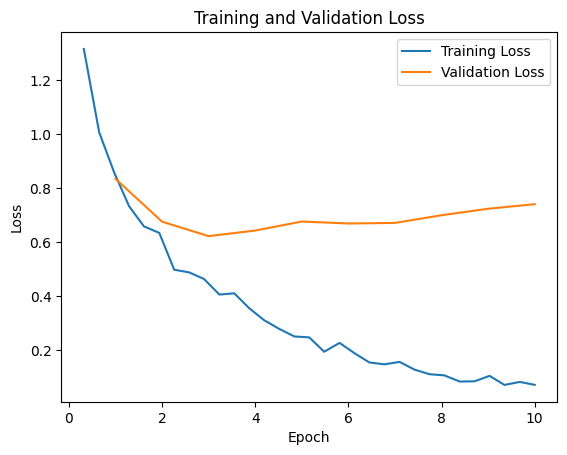

In [198]:
plt.plot(training_epochs, training_loss, label='Training Loss')
plt.plot(validation_epochs, validation_loss, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.legend()
plt.show()

# Evaluation using Overlapings for True Positives

In [9]:
import os
from datasets import Dataset
import time
import pandas as pd

In [219]:
# Read the JSON file

i = 0
current_dir = os.getcwd()
file_path = os.path.join(current_dir,'SC NER Dataset Version 2',f'dataset{i}.json')
with open(file_path, 'r') as file:
    json_data = file.read()

# Parse the JSON string into a dictionary
data = json.loads(json_data)

# Retrieve the lists from the dictionary
train_data = data['train']
test_data = data['test']

In [220]:
all_labels = set()
for input_string in train_data:
    lines = input_string.split("\n")
    for line in lines:
        if line.strip() != "":
            word, label = line.split(" ")
            all_labels.add(label)

In [221]:
labels_to_ids = {k: v for v, k in enumerate(all_labels)}
labels_to_ids

{'I-Development_Scalability': 0,
 'I-Transaction_Scalability': 1,
 'B-Transaction_Scalability': 2,
 'I-Company_Name': 3,
 'O': 4,
 'B-Data_Scalability': 5,
 'B-Development_Scalability': 6,
 'B-Software_Name': 7,
 'I-Data_Scalability': 8,
 'B-Company_Name': 9,
 'I-Software_Name': 10}

In [222]:
ids_to_labels = {id: tag for tag, id in labels_to_ids.items()}
ids_to_labels

{0: 'I-Development_Scalability',
 1: 'I-Transaction_Scalability',
 2: 'B-Transaction_Scalability',
 3: 'I-Company_Name',
 4: 'O',
 5: 'B-Data_Scalability',
 6: 'B-Development_Scalability',
 7: 'B-Software_Name',
 8: 'I-Data_Scalability',
 9: 'B-Company_Name',
 10: 'I-Software_Name'}

In [223]:
label_list = list(all_labels)
label_list

['I-Development_Scalability',
 'I-Transaction_Scalability',
 'B-Transaction_Scalability',
 'I-Company_Name',
 'O',
 'B-Data_Scalability',
 'B-Development_Scalability',
 'B-Software_Name',
 'I-Data_Scalability',
 'B-Company_Name',
 'I-Software_Name']

In [224]:
def get_texts_and_tags(BOI_list):
    # Initialize empty lists for sentences and word labels
    texts = []
    tags = []

    # Process each input string
    for input_string in BOI_list:
        lines = input_string.split("\n")
        sentence = []
        labels = []
        for line in lines:
            if line.strip() != "":
                word, label = line.split(" ")
                sentence.append(word)
                labels.append(labels_to_ids[label])
        texts.append(sentence)
        tags.append(labels)
    
    return texts, tags

In [225]:
test_texts, test_tags = get_texts_and_tags(test_data)

In [226]:
labels_to_labels = {'B-Transaction_Scalability': 'Transaction_Scalability',
 'I-Transaction_Scalability': 'Transaction_Scalability',
 'I-Software_Purpose': 'Software_Purpose',
 'B-Development_Scalability': 'Development_Scalability',
 'I-Development_Scalability': 'Development_Scalability',
 'B-Userbase_Information': 'Userbase_Information',
 'I-Userbase_Information': 'Userbase_Information',
 'B-Data_Scalability': 'Data_Scalability',
 'B-Software_Purpose': 'Software_Purpose',
 'B-Internal_Organization': 'Internal_Organization',
 'I-Internal_Organization': 'Internal_Organization',
 'I-Data_Scalability': 'Data_Scalability',
 'B-Software_Name': 'Software_Name',
 'I-Software_Name': 'Software_Name',
 'B-Company_Name': 'Company_Name',
 'I-Company_Name': 'Company_Name',
 'O': 'O'}

In [229]:
def find_sublist_index(larger_list, sublist):
    sublist_length = len(sublist)
    for i in range(len(larger_list) - sublist_length + 1):
        if larger_list[i:i+sublist_length] == sublist:
            return i
    return None


In [11]:
# number of labels in a list
dataset_label_nums = [17]

In [230]:
nlp = pipeline("ner", model=model_fine_tuned, tokenizer=tokenizer)

In [231]:
# Function that retireve the indices of an entity when we split the original sentence into a list of tokens
def find_entities(labels):
    entities = {}
    start_idx = None

    for idx, label in enumerate(labels):
        if label.startswith('B-'):
            # Found the start of an entity
            if start_idx is not None:
                # Add the previous entity to the dictionary
                entity = labels[start_idx].split('-')[1]
                entities[entity] = entities.get(entity,[]) + [list(range(start_idx, idx))]
            
            start_idx = idx
        elif label.startswith('I-'):
            # Continue the current entity
            if start_idx is None:
                start_idx = idx
        else:
            # End of entity
            if start_idx is not None:
                entity = labels[start_idx].split('-')[1]
                entities[entity] = entities.get(entity,[]) + [list(range(start_idx, idx))]
                start_idx = None

    # Check if there's an entity that spans till the end of the list
    if start_idx is not None:
        entity = labels[start_idx].split('-')[1]
        entities[entity] = entities.get(entity,[]) + [list(range(start_idx, len(labels)))]

    return entities

labels = ['O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'B-PER', 'I-PER', 'O']
entity_indices = find_entities(labels)
print(entity_indices)

{'ORG': [[2, 3, 4]], 'PER': [[6, 7]]}


In [232]:
# Function that run through the full NER pipeline and return the predictions in a custom format
def ner_pipeline(nlp, sentence, tags):
    # NER model
    ner = nlp(sentence)
    
    # Get the tokenized input of the original sentence
    tokenized_input = tokenizer(sentence, is_split_into_words=True)
    tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
    
    # Get the word id and match the labels to the corresponding entitiy
    word_ids = tokenized_input.word_ids()
    aligned_labels = ['O' if i is None else ids_to_labels[tags[i]] for i in word_ids]
    
    entity_indices = find_entities(aligned_labels)
    
    ner_result = ['O'] * len(tokens) 

    ner_result_indices = {}
    count = 0
    for item in ner:
        part_tokens = []
        coresponding_tags = []
        for entity in item:
            
            #Adding a threshold
            if entity['score'] > 0.3:
                coresponding_tags.append(entity['entity'])
                part_tokens.append(entity['word'])
        
        # Finding the index where the sequence of tokens are located in the string
        index = find_sublist_index(tokens, part_tokens)
        if index:
            all_indexes = range(index, index+len(part_tokens))
            for i, value in enumerate(all_indexes):
                ner_result[value] = coresponding_tags[i]
            
            # Adding the location of the tags
            temp = labels_to_labels[item[0]['entity']]
            ner_result_indices[temp] = ner_result_indices.get(temp, []) + [list(all_indexes)]
        
    
    return entity_indices, ner_result_indices
    

In [233]:
# Class to save predicition results
class Score_Container:
    def __init__(self):
        self.tp = 0
        self.tn = 0
        self.fp = 0
        self.fp2 = 0
        self.fn = 0

In [234]:
# Creating a score container
scores_by_entity = {}
for i in set(labels_to_labels.values()):
    scores_by_entity[i] = Score_Container()

In [235]:
# Function that categorizes the predictions of a sentence accordingly
def get_scores(ner_result, correct_tags):
    tp, tn, fp, fn = 0, 0, 0, 0
    
    # Making a flat list of all the indexes that contain an entity
    correct_tags_positions = []
    for n in correct_tags:
        flat_list = [item for sublist in correct_tags[n] for item in sublist]
        correct_tags_positions += flat_list
    
    ner_result_positions = []
    for n in ner_result:
        flat_list = [item for sublist in ner_result[n] for item in sublist]
        ner_result_positions += flat_list
    
    for n in ner_result:
        for sublist1 in ner_result[n]:
            if n in correct_tags:
                found = False
                for sublist2 in correct_tags[n]:
                    if set(sublist1) & set(sublist2):
                        # Assigns the correct entity in the text
                        tp += 1
                        found = True
                        scores_by_entity[n].tp += 1
                if not found and set(sublist1) & set(correct_tags_positions): 
                    # Fails to assign the correct entity but overlaps with another entity
                    fp += 1
                    scores_by_entity[n].fp += 1
                    found = True
                if not found:
                    # Assigned a label to a non-entity
                    fp += 1
                    scores_by_entity[n].fp2 += 1
            else:
                found = False
                if set(sublist1) & set(correct_tags_positions): 
                    # Fails to assign the correct entity but overlaps with another entity
                    fp += 1
                    scores_by_entity[n].fp += 1
                    found = True
                if not found:
                    # Assigned a label to a non-entity
                    fp += 1
                    scores_by_entity[n].fp2 += 1
                
                
    
    for n in correct_tags:
        for sublist2 in correct_tags[n]:
            if not set(sublist2) & set(ner_result_positions):
                fn += 1
                scores_by_entity[n].fn += 1
    
    return tp, tn, fp, fn           
        
    

In [236]:
# Computing the prediction scores for each sentence

true_positives, true_negatives, false_positives, false_negatives = 0, 0, 0, 0
start_time = time.time()
for i, sentence in enumerate(test_texts):
    correct_tags, ner_result = ner_pipeline(nlp, sentence, test_tags[i])
    tp, tn, fp, fn = get_scores(ner_result, correct_tags)
    true_positives += tp
    true_negatives += tn
    false_positives += fp
    false_negatives += fn
    
#     print(ner_result)
#     print(correct_tags)
#     if i > 10:
#         break

end_time = time.time()
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed Time: {elapsed_time} seconds")


Elapsed Time: 226.23659253120422 seconds


In [237]:
index = list(scores_by_entity.keys())
columns = ['tp','tn','fp','fp2','fn']

data = []
for i in scores_by_entity:
    temp = [scores_by_entity[i].tp,scores_by_entity[i].tn,scores_by_entity[i].fp,scores_by_entity[i].fp2,scores_by_entity[i].fn]
    data.append(temp)
    
# Create the DataFrame with specified columns and index
df = pd.DataFrame(data, columns=columns, index=index)

# Print the DataFrame
print(df)

                         tp  tn   fp  fn  fn2
Data_Scalability         58   0   19  18   43
Transaction_Scalability  32   0   23   2   70
Software_Name            69   0  104  80  107
O                         0   0    0   0    0
Development_Scalability  35   0   17   4  174
Company_Name             48   0   83  53   35


In [238]:
print(true_positives, true_negatives, false_positives, false_negatives)

242 0 246 586


In [239]:
precision = true_positives/(true_positives+false_positives)
precision

0.4959016393442623

In [240]:
recall = true_positives/(true_positives+false_negatives)
recall

0.2922705314009662

In [241]:
f1 = (true_positives)/(true_positives+0.5*(false_positives+false_negatives))
f1

0.3677811550151976